In [1]:
from keras.utils import np_utils
from src.models import *
from src.viz import *
import tensorflow as tf
from keras.datasets import mnist
from keras.datasets import fashion_mnist
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K


physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
def load_prep_data2D():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    visualize_fashion_mnist([1,2,3,4,5])
    # Introduce mono-channel shape
    x_train = x_train.reshape(x_train.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')
    # Scale data
    x_train = x_train / 255
    x_test = x_test / 255
    # One-hot encode targets
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]
    return (x_train, y_train), (x_test, y_test), num_classes 
    

def load_prep_data1D(noise=False):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # Scale data
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    # Reshape data (vector instead of matrix of pixels)
    num_pixels = x_train.shape[1] * x_train.shape[2]
    x_train = x_train.reshape(len(x_train), num_pixels)
    x_test = x_test.reshape(len(x_test), num_pixels)
    
    if(noise):
        # Sum random values to the samples, in order to introduce noise
        x_train = x_train + np.random.normal(loc=0.0, scale=0.5, size=x_train.shape)
        x_train = np.clip(x_train, 0., 1.) # don't allow values < 0 or > 1

        x_test = x_test + np.random.normal(loc=0.0, scale=0.5, size=x_test.shape)
        x_test = np.clip(x_test, 0., 1.) 
    
    visualize_mnist([1,2,3,4,5], data=x_train)
    
    # One-hot encode targets
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]
    return (x_train, y_train), (x_test, y_test), num_classes 

In [3]:
def run_simple(name, epochs=50, batch_size=256):
    (x_train, y_train), (x_test, y_test), num_classes = load_prep_data1D()
    
    # Build model
    autoencoder, encoder = create_model(name, x_train.shape[1], num_classes)
    print_model(autoencoder,f"img/{name}.png")
    autoencoder.summary()
    
    # Train the model
    history = autoencoder.fit(x_train, x_train, 
                        validation_data=(x_test, x_test), 
                        epochs=epochs, 
                        batch_size=batch_size,
                        shuffle=True,
                        verbose=0)
    
    plot_history_metrics(history, ['accuracy', 'loss'])
    
    visualize_predictions(autoencoder, x_test)
    
    return history

def run_denoiser(name, epochs=50, batch_size=256):
    (x_train, y_train), (x_test, y_test), num_classes = load_prep_data1D(noise=True)
    
    # Build model
    autoencoder, encoder = create_model(name, x_train.shape[1], num_classes)
    print_model(autoencoder,f"img/{name}.png")
    autoencoder.summary()
    
    # Train the model
    history = autoencoder.fit(x_train, x_train, 
                        validation_data=(x_test, x_test), 
                        epochs=epochs, 
                        batch_size=batch_size,
                        shuffle=True,
                        verbose=0)
    
    plot_history_metrics(history, ['accuracy', 'loss'])
    
    visualize_predictions(autoencoder, x_test)
    
    return history


def run_vae(epochs=50, batch_size=256):
    (x_train, y_train), (x_test, y_test), num_classes = load_prep_data2D()

    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

    # Build model
    vae, t_mean, t_log_var, encoder = create_model('vae', input_shape, None)
    print_model(vae, "img/vae.png")
    vae.summary()

    # Train the model
    history = vae.fit(x_train, x_train, 
                      validation_data=(x_test, x_test), 
                      epochs=epochs, 
                      batch_size=batch_size,
                      shuffle=True,
                      verbose=0)

    plot_history_metrics(history, ['accuracy', 'loss'])    
    visualize_predictions(vae, x_test)

    tt_test = encoder.predict(x_test)
    t_mean_test = tt_test[0]
    t_log_var_test = tt_test[1]

    (_, _), (_, viz_y_test) = fashion_mnist.load_data()
    plot_latent_v2(t_mean_test, viz_y_test, fashion_mnist=True)
    
    return history

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


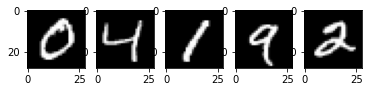

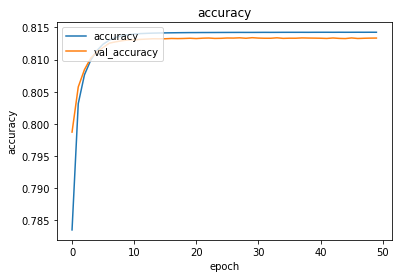

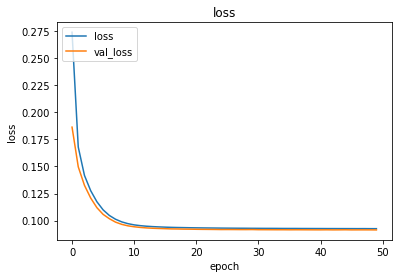

Original Images - first 10 images of test dataset


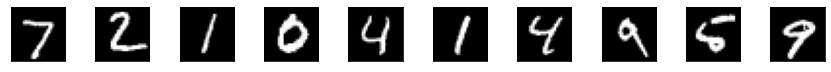

Decoded Images - predictions of first 10 images of test dataset


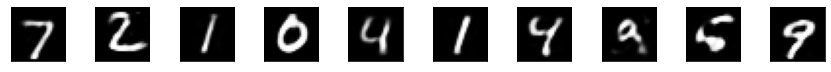

In [4]:
run_simple('autoencoderv1')

In [ ]:
run_simple('autoencoderv2')

In [ ]:
run_denoiser('autoencoderv2')

In [ ]:
run_vae(batch_size=64)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               1011

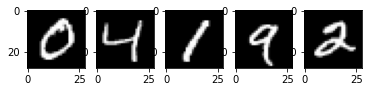

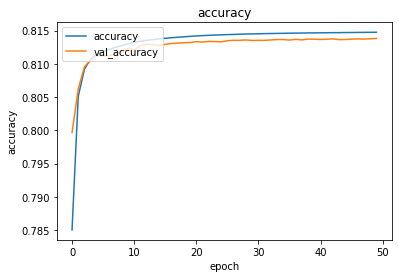

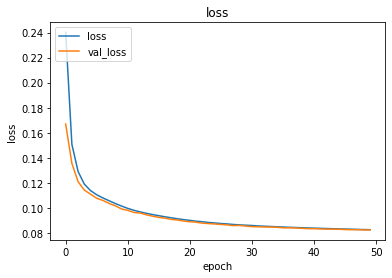

Original Images - first 10 images of test dataset


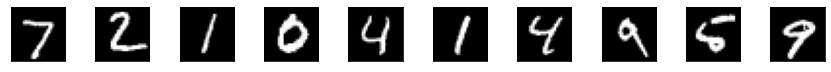

Decoded Images - predictions of first 10 images of test dataset


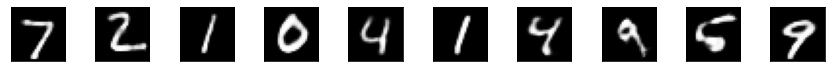

In [5]:
run_vae(batch_size=64)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_13 (Dense)             (None, 784)               1011

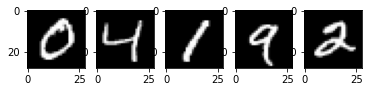

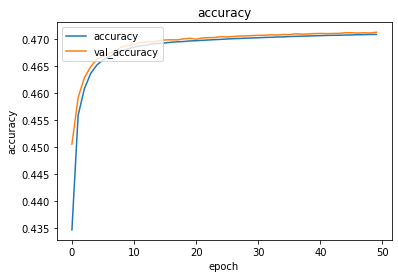

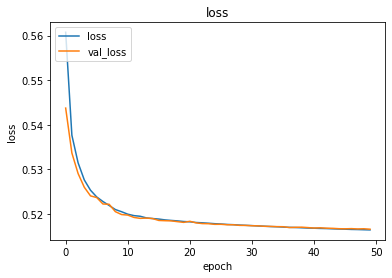

Original Images - first 10 images of test dataset


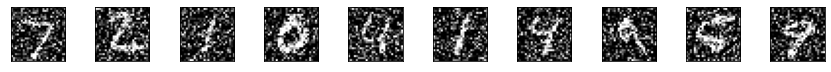

Decoded Images - predictions of first 10 images of test dataset


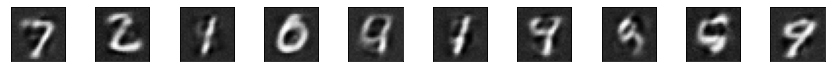

In [6]:
run_denoiser('autoencoderv2')

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 494244      input_1[0][0]                    
__________________________________________________________________________________________________
sampler (Lambda)                (None, 2)            0           encoder[1][0]                    
                                                                 encoder[1][1]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    56385       sampler[0][0]                  

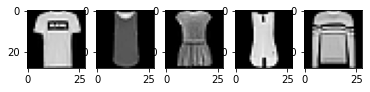

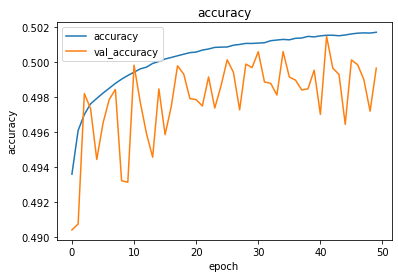

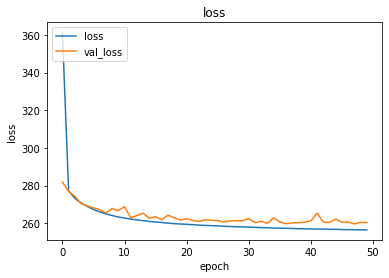

Original Images - first 10 images of test dataset


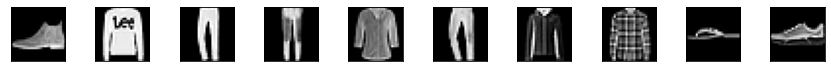

Decoded Images - predictions of first 10 images of test dataset


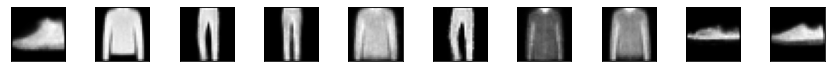

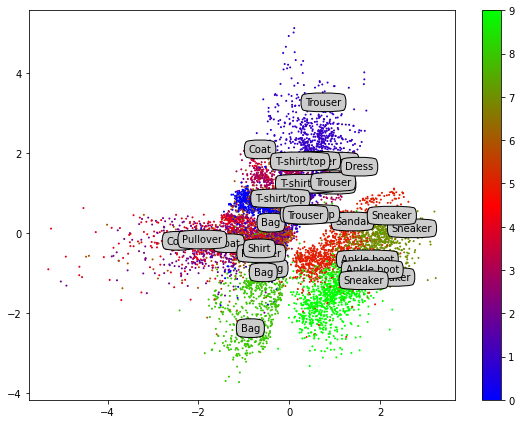

In [4]:
run_vae(batch_size=64)